## Project Code

In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.7":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.7":
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.18.5", 'matplotlib': "3.2.2",'sklearn': "0.23.1", 
                'pandas': "1.0.5",'xgboost': "1.1.1", 'shap': "0.35.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]

[ OK ] numpy version 1.18.5 is installed.
[ OK ] matplotlib version 3.2.2 is installed.
[ OK ] sklearn version 0.23.1 is installed.
[ OK ] pandas version 1.0.5 is installed.
[ OK ] xgboost version 1.1.1 is installed.
[ OK ] shap version 0.35.0 is installed.


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import math
from matplotlib import pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

## For a given national park, given a species of specific nativeness, order and family, can we predict abundance?

**Step 1**

Read data into the cell 

In [3]:
# read in the data in this cell
df1 = pd.read_csv('data/species.csv', low_memory=False)
df1 = df1.loc[:, df1.columns != 'Unnamed: 13']
# print(df1)

In [4]:
df2 = pd.read_csv('data/parks.csv')
# print(df2)

In [5]:
df = df1.merge(df2,how='outer',on='Park Name')  # merging on IDs present in any dataframe
print(df)

       Species ID             Park Name        Category          Order  \
0       ACAD-1000  Acadia National Park          Mammal   Artiodactyla   
1       ACAD-1001  Acadia National Park          Mammal   Artiodactyla   
2       ACAD-1002  Acadia National Park          Mammal      Carnivora   
3       ACAD-1003  Acadia National Park          Mammal      Carnivora   
4       ACAD-1004  Acadia National Park          Mammal      Carnivora   
...           ...                   ...             ...            ...   
119243  ZION-2791    Zion National Park  Vascular Plant      Solanales   
119244  ZION-2792    Zion National Park  Vascular Plant        Vitales   
119245  ZION-2793    Zion National Park  Vascular Plant        Vitales   
119246  ZION-2794    Zion National Park  Vascular Plant  Zygophyllales   
119247  ZION-2795    Zion National Park  Vascular Plant  Zygophyllales   

                Family         Scientific Name  \
0             Cervidae             Alces alces   
1          

In [6]:
# df = df[(df['Record Status']!='Approved')]

df.shape

(119248, 18)

The following columns seem irrelevant to the model: 
1) Species ID



3) Common Names

4) Park Code

5) State

In [7]:
df = df.loc[:, df.columns != 'Species ID']
df = df.loc[:, df.columns != 'Common Names']
df = df.loc[:, df.columns != 'Park Code']
# df = df.loc[:, df.columns != 'State']
print(df.shape)

(119248, 15)


In [8]:
# df2 = df[(df['Category']!='Vascular Plant')]
# df2 = df2[(df2['Category']!='Nonvascular Plant')]

In [9]:
# df.dropna(subset=['Abundance'], inplace=True)                  Not dropping, converting to "Missing"
#for x in df['Abundance']:                              # iterates through each value in each column
#    if math.isnan(x)==True:             # if value is NaN and the column index for missing values has not been registered
#        print(i)
#        #col_missing = i
# values = {'Abundance': 'Missing'}      # value = values
df.fillna("Missing", inplace = True)

df.shape
df

,Park Name,Category,Order,Family,Scientific Name,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,State,Acres,Latitude,Longitude
0,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Approved,Present,Native,Rare,Resident,Missing,ME,47390,44.35,-68.21
1,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,Approved,Present,Native,Abundant,Missing,Missing,ME,47390,44.35,-68.21
2,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,Approved,Present,Not Native,Common,Missing,Species of Concern,ME,47390,44.35,-68.21
3,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,Approved,Not Confirmed,Native,Missing,Missing,Endangered,ME,47390,44.35,-68.21
4,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,Approved,Present,Unknown,Common,Breeder,Missing,ME,47390,44.35,-68.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119243,Zion National Park,Vascular Plant,Solanales,Solanaceae,Solanum triflorum,Approved,Present,Native,Uncommon,Missing,Missing,UT,146598,37.30,-113.05
119244,Zion National Park,Vascular Plant,Vitales,Vitaceae,Vitis arizonica,Approved,Present,Native,Uncommon,Missing,Missing,UT,146598,37.30,-113.05
119245,Zion National Park,Vascular Plant,Vitales,Vitaceae,Vitis vinifera,Approved,Present,Not Native,Uncommon,Missing,Missing,UT,146598,37.30,-113.05
119246,Zion National Park,Vascular Plant,Zygophyllales,Zygophyllaceae,Larrea tridentata,Approved,Present,Native,Rare,Missing,Missing,UT,146598,37.30,-113.05


In [10]:
df2 = df[(df['Category']!='Vascular Plant')]
df2 = df2[(df2['Category']!='Nonvascular Plant')]
df2.shape

(49749, 15)

1) Relative abundance

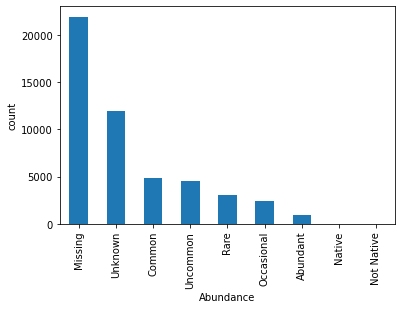

In [11]:
pd.value_counts(df2['Abundance']).plot.bar()
plt.ylabel('count')
plt.xlabel('Abundance')
plt.show()

In [12]:
# df = df[(df['Abundance']=="Uncommon")|(df['Abundance']=="Common")|(df['Abundance']=="Rare")|(df['Abundance']=="Occasional")|(df['Abundance']=="Abundant")]
# print(df.shape)
# print(df[(df['Category']=='Vascular Plant')].shape)
df2 = df2[(df2['Abundance']!='Native')]
df2 = df2[(df2['Abundance']!='Not Native')]
df2.shape
df = df2
df

,Park Name,Category,Order,Family,Scientific Name,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,State,Acres,Latitude,Longitude
0,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Approved,Present,Native,Rare,Resident,Missing,ME,47390,44.35,-68.21
1,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,Approved,Present,Native,Abundant,Missing,Missing,ME,47390,44.35,-68.21
2,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,Approved,Present,Not Native,Common,Missing,Species of Concern,ME,47390,44.35,-68.21
3,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,Approved,Not Confirmed,Native,Missing,Missing,Endangered,ME,47390,44.35,-68.21
4,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,Approved,Present,Unknown,Common,Breeder,Missing,ME,47390,44.35,-68.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117880,Zion National Park,Fish,Salmoniformes,Salmonidae,Oncorhynchus clarkii utah,Approved,Present,Not Native,Occasional,Breeder,Missing,UT,146598,37.30,-113.05
117881,Zion National Park,Fish,Salmoniformes,Salmonidae,Oncorhynchus mykiss,Approved,Present,Not Native,Unknown,Breeder,Missing,UT,146598,37.30,-113.05
117882,Zion National Park,Fish,Salmoniformes,Salmonidae,Salmo trutta,Approved,Present,Not Native,Uncommon,Breeder,Missing,UT,146598,37.30,-113.05
117883,Zion National Park,Fish,Salmoniformes,Salmonidae,Salvelinus fontinalis,Approved,Present,Not Native,Occasional,Breeder,Missing,UT,146598,37.30,-113.05


In [13]:
print("Park Name: ", pd.unique(df2['Park Name']).shape[0])
print("Category: ", pd.unique(df2['Category']).shape[0])
print("Order: ", pd.unique(df2['Order']).shape[0])
print("Family: ", pd.unique(df2['Family']).shape[0])

Park Name:  56
Category:  12
Order:  412
Family:  1869


In [14]:
print("Scientific Names: ", pd.unique(df2['Scientific Name']).shape[0])

Scientific Names:  22676


## EDA

1) Park Name

In [15]:
print("Park Name: ", pd.unique(df2['Park Name']).shape[0])
pd.value_counts(df2['Park Name'])

Park Name:  56


Great Smoky Mountains National Park               3921
Redwood National Park                             3802
Yellowstone National Park                         2531
Death Valley National Park                        2159
Hawaii Volcanoes National Park                    1951
Crater Lake National Park                         1939
Rocky Mountain National Park                      1622
Shenandoah National Park                          1544
North Cascades National Park                      1500
Congaree National Park                            1430
Haleakala National Park                           1353
Biscayne National Park                            1172
Great Basin National Park                         1088
Glacier Bay National Park and Preserve            1037
Channel Islands National Park                      993
Joshua Tree National Park                          974
Everglades National Park                           914
Glacier National Park                              886
Grand Cany

2) Category

In [16]:
print("Category: ", pd.unique(df2['Category']).shape[0])

Category:  12


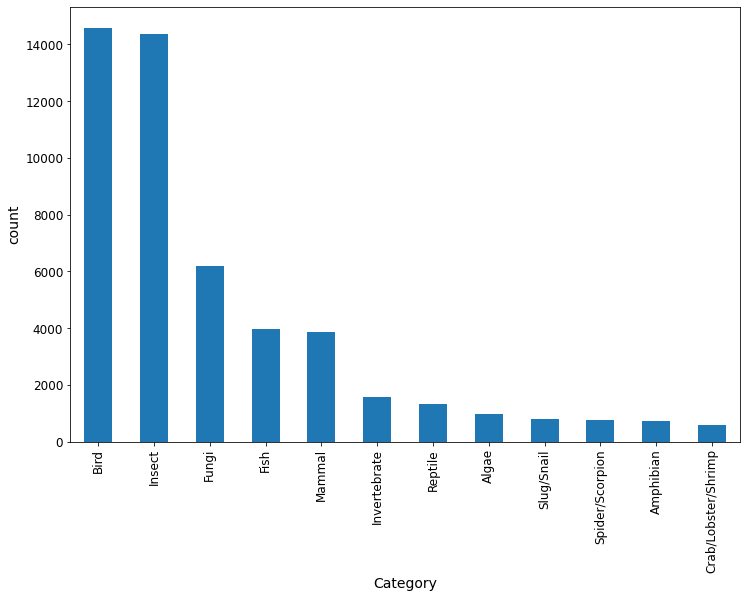

In [17]:
pd.value_counts(df2['Category']).plot.bar(figsize = (12, 8))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('count', fontsize = 14)
plt.xlabel('Category', fontsize = 14)
plt.savefig("figures\Category Bar Plot")

3) Order

In [18]:
print("Order: ", pd.unique(df2['Order']).shape[0])

Order:  412


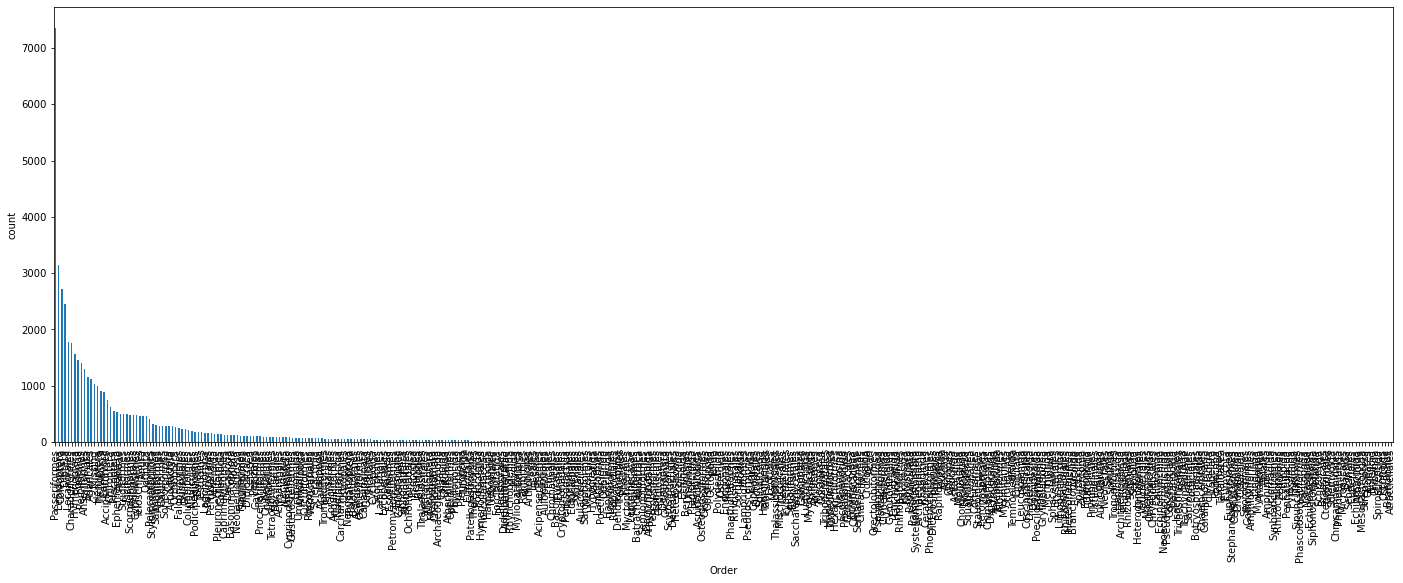

In [19]:
pd.value_counts(df2['Order']).plot.bar(figsize = (24, 8))      # too many to be useful bar plot
plt.ylabel('count')
plt.xlabel('Order')
plt.savefig("figures\Order Bar Plot")

4) Family

In [20]:
print("Family: ", pd.unique(df2['Family']).shape[0])

Family:  1869


5) Scientific Names

In [21]:
print("Scientific Name: ", pd.unique(df2['Scientific Name']).shape[0])

Scientific Name:  22676


6) Record Status

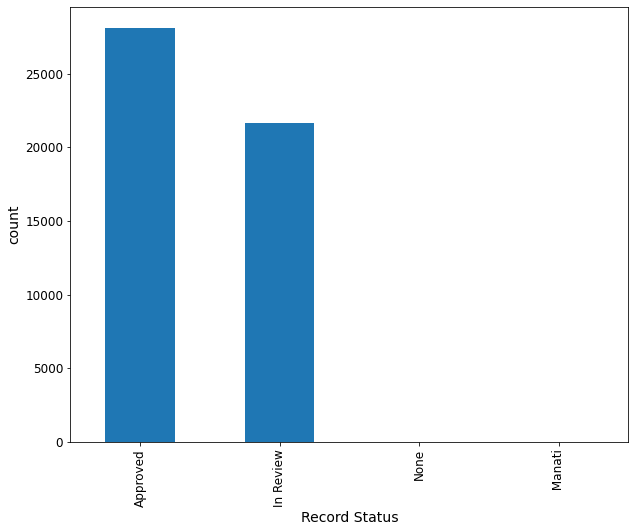

In [22]:
pd.value_counts(df2['Record Status']).plot.bar(figsize = (10, 8))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('count', fontsize = 14)
plt.xlabel('Record Status', fontsize = 14)
plt.savefig("figures\Record Status Bar Plot")

7) Occurrence

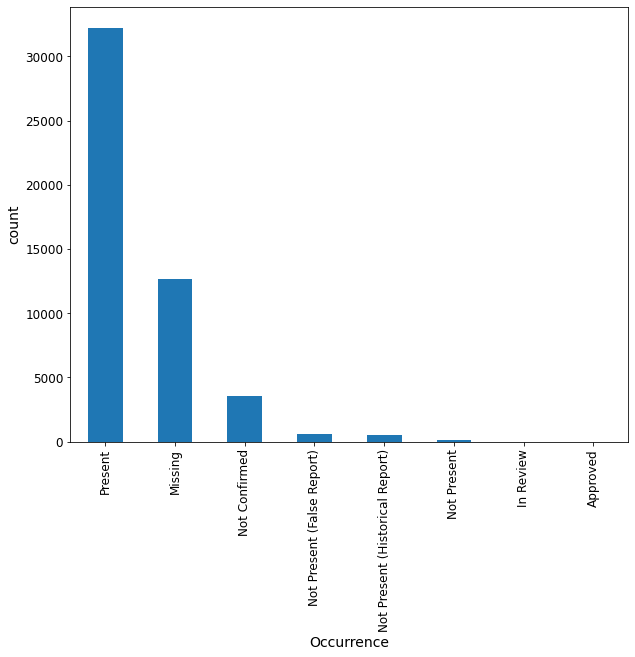

In [23]:
pd.value_counts(df2['Occurrence']).plot.bar(figsize = (10, 8))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('count', fontsize = 14)
plt.xlabel('Occurrence', fontsize = 14)
plt.savefig("figures\Occurence Bar Plot")

8) Nativeness

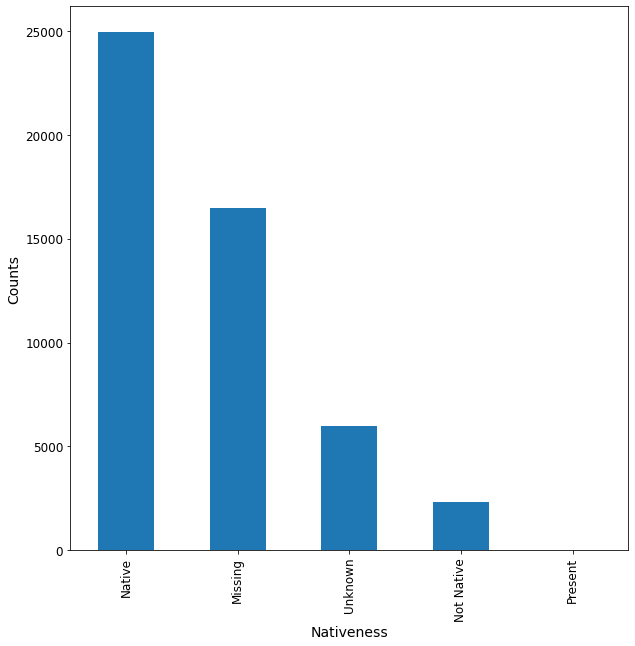

In [24]:
pd.value_counts(df2['Nativeness']).plot.bar(figsize = (10, 10))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Counts', fontsize = 14)
plt.xlabel('Nativeness', fontsize = 14)
plt.savefig("figures\Bar Plot Nativeness")

9) Seasonality

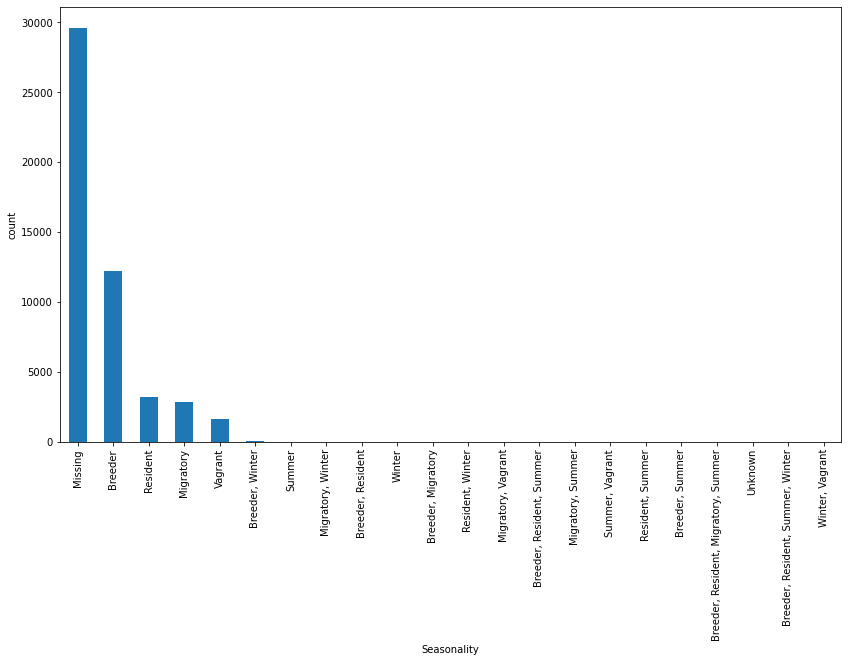

In [25]:
pd.value_counts(df2['Seasonality']).plot.bar(figsize = (14, 8))
plt.ylabel('count')
plt.xlabel('Seasonality')
plt.savefig("figures\Seasonality Bar Plot")

10) Conservation Status

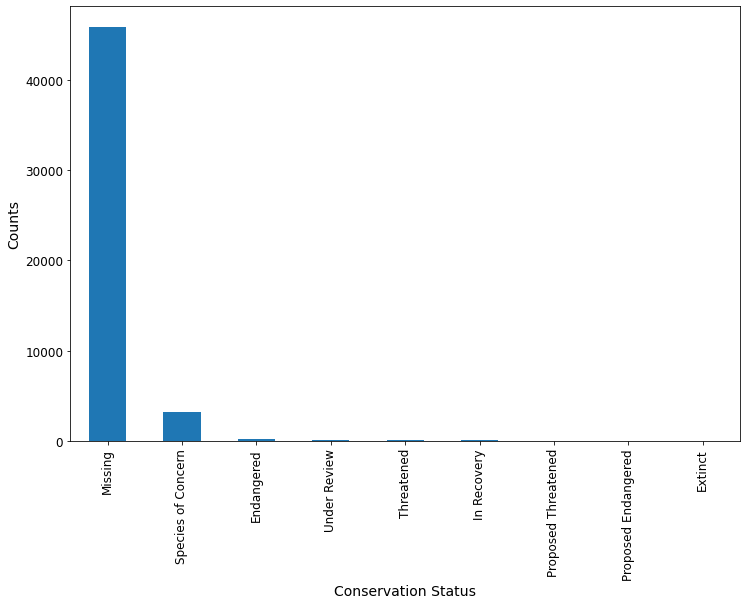

In [26]:
pd.value_counts(df2['Conservation Status']).plot.bar(figsize = (12, 8))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Counts', fontsize = 14)
plt.xlabel('Conservation Status', fontsize = 14)
plt.savefig("figures\Conservation Status Bar Plot")

11) State

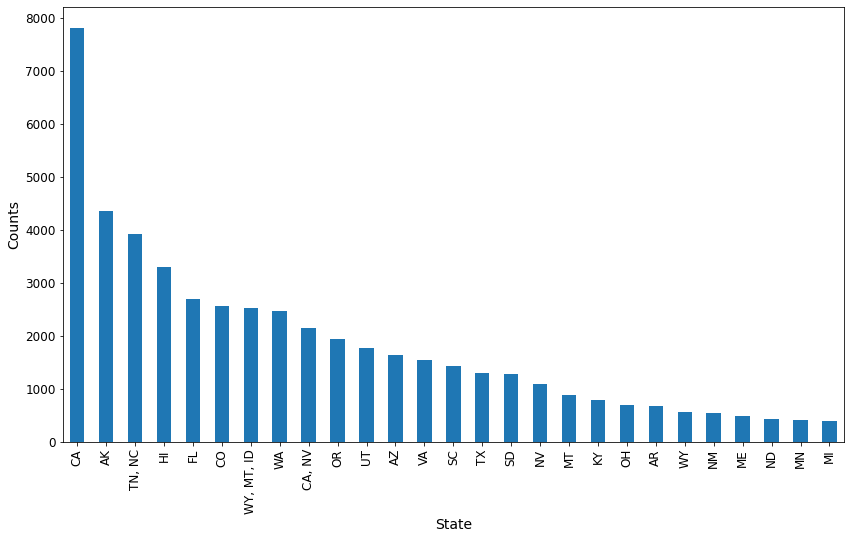

In [27]:
pd.value_counts(df2['State']).plot.bar(figsize = (14, 8))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Counts', fontsize = 14)
plt.xlabel('State', fontsize = 14)
plt.savefig("figures\State Bar Plot")

12) Acres (Area of Park)

In [28]:
print(pd.DataFrame.describe(df2['Acres']))

count    4.973500e+04
mean     9.263751e+05
std      1.558872e+06
min      5.550000e+03
25%      1.063720e+05
50%      2.658280e+05
75%      8.011630e+05
max      8.323148e+06
Name: Acres, dtype: float64


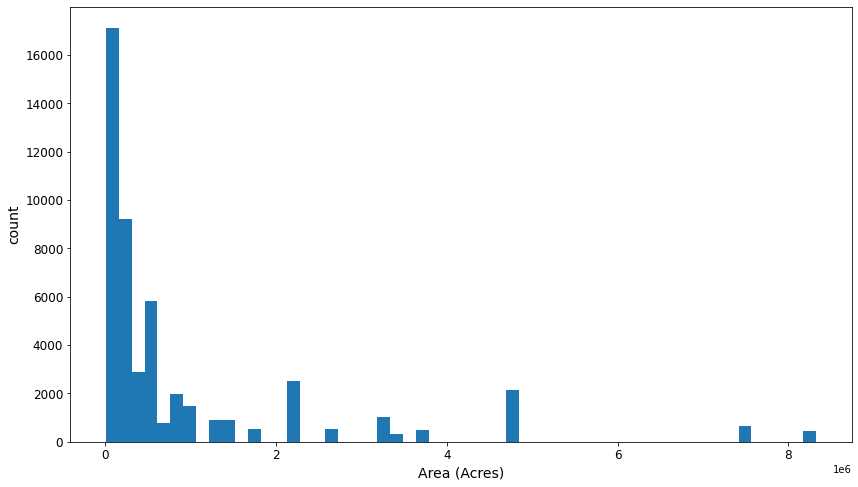

In [29]:
df2['Acres'].plot.hist(bins = df2['Acres'].nunique(), figsize = (14, 8))
# plt.semilogx()
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Area (Acres)', fontsize = 14)
plt.ylabel('count', fontsize = 14)
plt.savefig("figures\Area Histogram")

13) Latitude

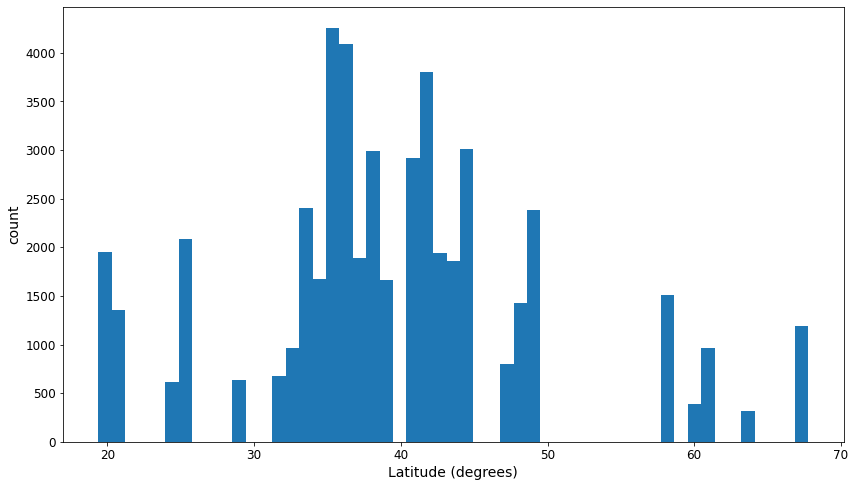

In [30]:
df2['Latitude'].plot.hist(bins = df2['Latitude'].nunique(), figsize = (14, 8))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Latitude (degrees)', fontsize = 14)
plt.ylabel('count', fontsize = 14)
plt.savefig("figures\Latitude Histogram")

14) Longitude

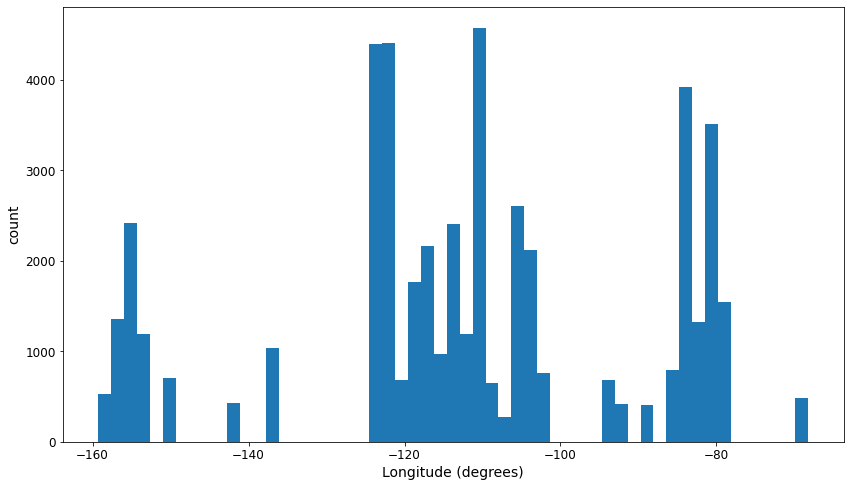

In [31]:
df2['Longitude'].plot.hist(bins = df2['Longitude'].nunique(), figsize = (14, 8))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Longitude (degrees)', fontsize = 14)
plt.ylabel('count', fontsize = 14)
plt.savefig("figures\Longitude Histogram")

15) Abundance

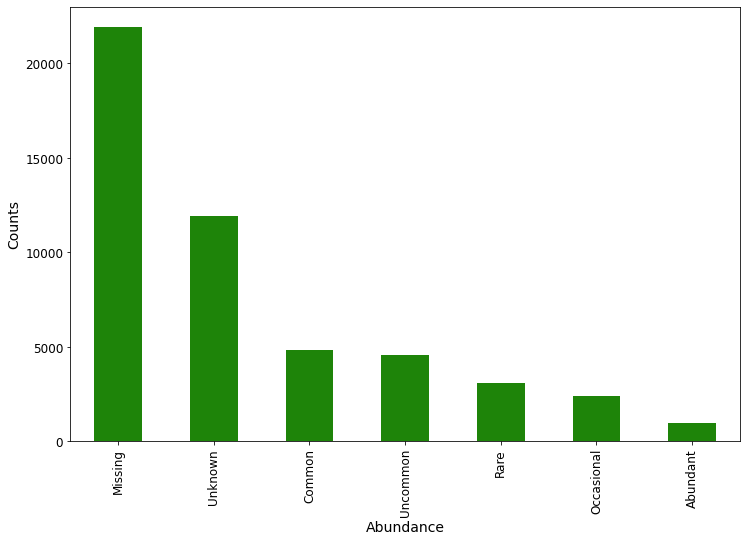

In [32]:
pd.value_counts(df2['Abundance']).plot.bar(figsize = (12, 8), color = '#1E8409')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Counts', fontsize = 14)
plt.xlabel('Abundance', fontsize = 14)
plt.savefig("figures\Abundance Bar Plot")

16) Scatter Matrix for the DataFrame

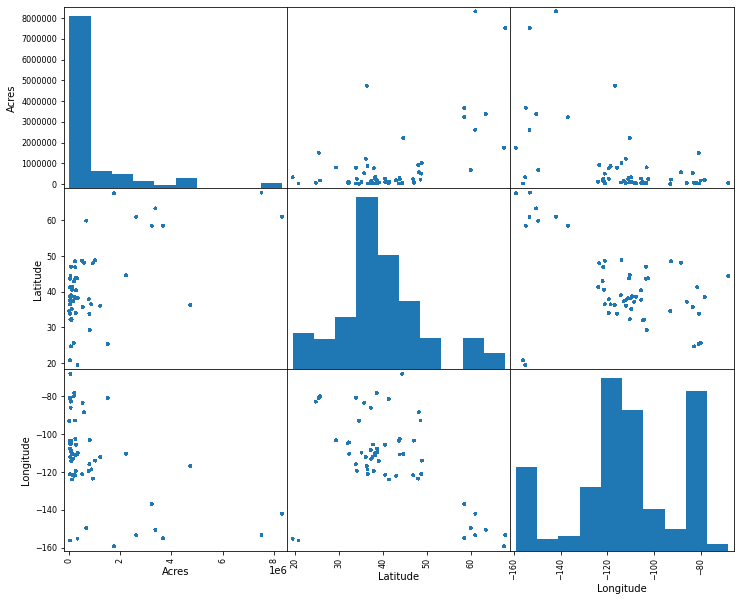

In [33]:
pd.plotting.scatter_matrix(df2, alpha = 0.2, figsize = (12, 10))
plt.savefig("figures\Scatter Matrix")

### 2 Variable EDA

1) Category vs. Park Name: Stacked bar plot: Gives a rough estimate of diversity in every park

In [34]:
df = df2

count_matrix = df.groupby(['Park Name', 'Category']).size().unstack()
#print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
# print(count_matrix_norm)

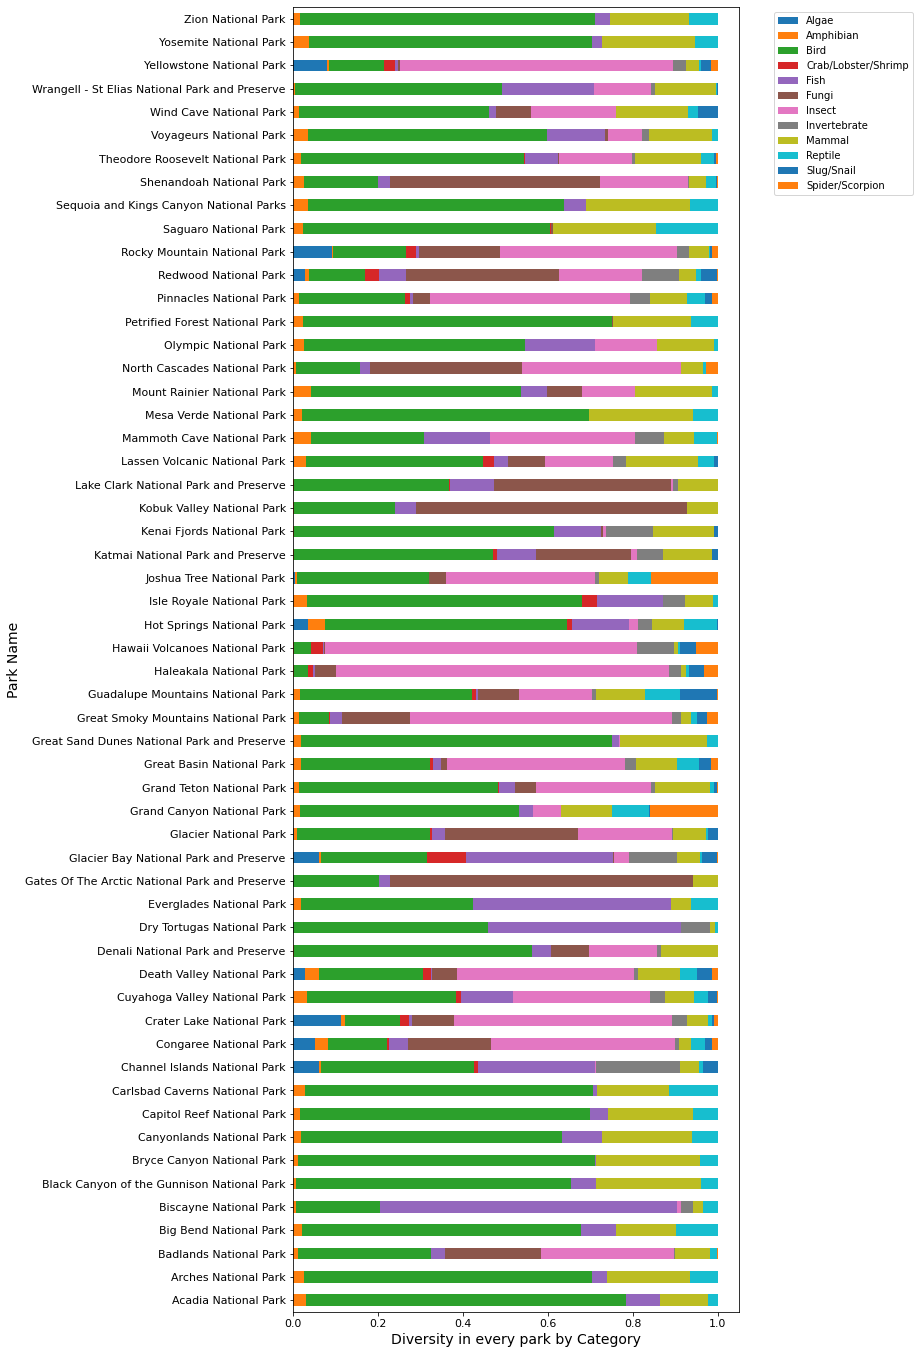

In [35]:
count_matrix_norm.plot.barh(stacked=True, figsize = (8, 24))

# plt.xticks(rotation = 30, rotation_mode = "anchor", verticalalignment = "top", fontsize = 12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.ylabel('Park Name', fontsize = 14)
plt.xlabel('Diversity in every park by Category', fontsize = 14)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.savefig("figures\Category vs Park Name Stacked Bar Plot")

2) Category vs. area of park: Is there a relationship between the 2? Maybe bigger parks have more diversity? Or is that there are fewer big parks to begin with? Ranges of diversity discussion as well.

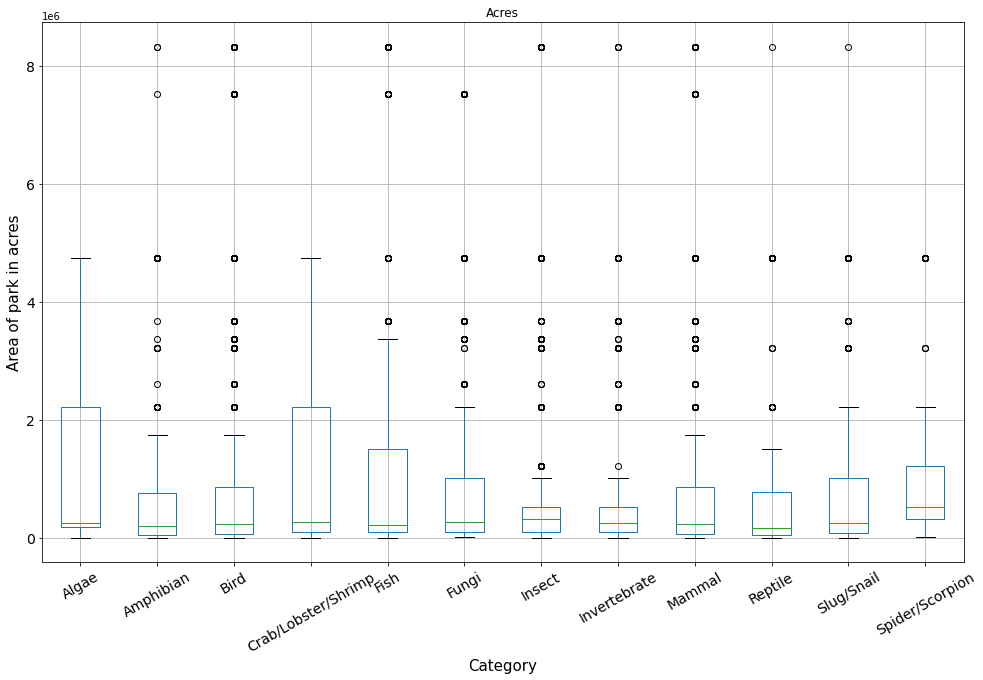

In [36]:
df2[['Acres','Category']].boxplot(by='Category', figsize = (16, 10))
plt.xticks(rotation = 30, rotation_mode = "default", fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Category', fontsize = 15)
plt.ylabel('Area of park in acres', fontsize = 15)
plt.suptitle("")
plt.savefig("figures\Category vs Area Boxplot")

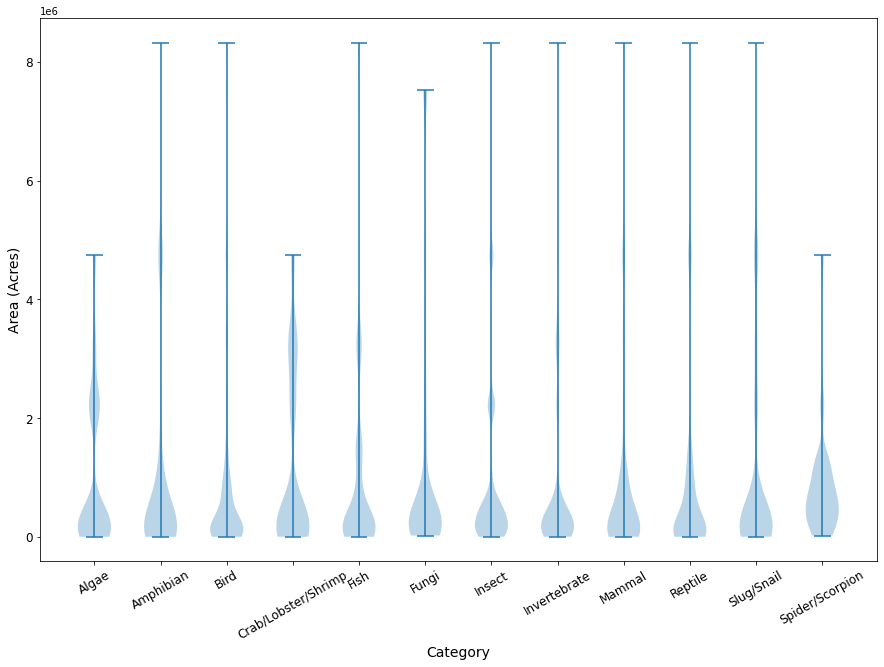

In [37]:
df = df2
dataset = [df[df['Category']=='Algae']['Acres'].values,
           df[df['Category']=='Amphibian']['Acres'].values,
           df[df['Category']=='Bird']['Acres'].values,
           df[df['Category']=='Crab/Lobster/Shrimp']['Acres'].values,
           df[df['Category']=='Fish']['Acres'].values,
           df[df['Category']=='Fungi']['Acres'].values,
           df[df['Category']=='Insect']['Acres'].values,
           df[df['Category']=='Invertebrate']['Acres'].values,
           df[df['Category']=='Mammal']['Acres'].values,
           df[df['Category']=='Reptile']['Acres'].values,
           df[df['Category']=='Slug/Snail']['Acres'].values,
           df[df['Category']=='Spider/Scorpion']['Acres'].values]

fig, ax = plt.subplots(figsize = (15, 10))
plt.violinplot(dataset = dataset)
plt.xticks([1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],['Algae', 'Amphibian', 'Bird', 'Crab/Lobster/Shrimp', 'Fish', 'Fungi', 'Insect', 'Invertebrate', 'Mammal', 'Reptile', 'Slug/Snail', 'Spider/Scorpion'], rotation = 30, rotation_mode = "default", fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Category', fontsize = 14)
plt.ylabel('Area (Acres)', fontsize = 14)
plt.savefig("figures\Category vs Park Name Violin Plot")

3) Nativeness vs. area of park: Category-specific histograms

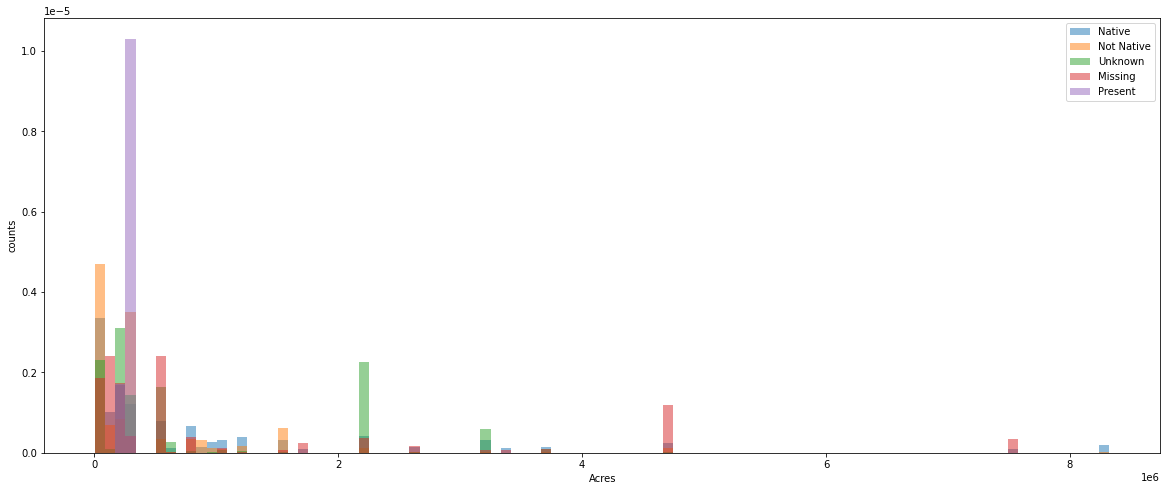

In [38]:
categories = df['Nativeness'].unique()
bin_range = (df['Acres'].min(),df['Acres'].max())

plt.figure(figsize = (20, 8))
for c in categories:
    plt.hist(df[df['Nativeness']==c]['Acres'],alpha=0.5,label=c,range=bin_range,bins=100,density=True)
# plt.semilogx()
plt.legend()
plt.ylabel('counts')
plt.xlabel('Acres')
plt.savefig("figures\Column Nativeness vs area of park category specific histograms")

4) Nativeness vs Longitude

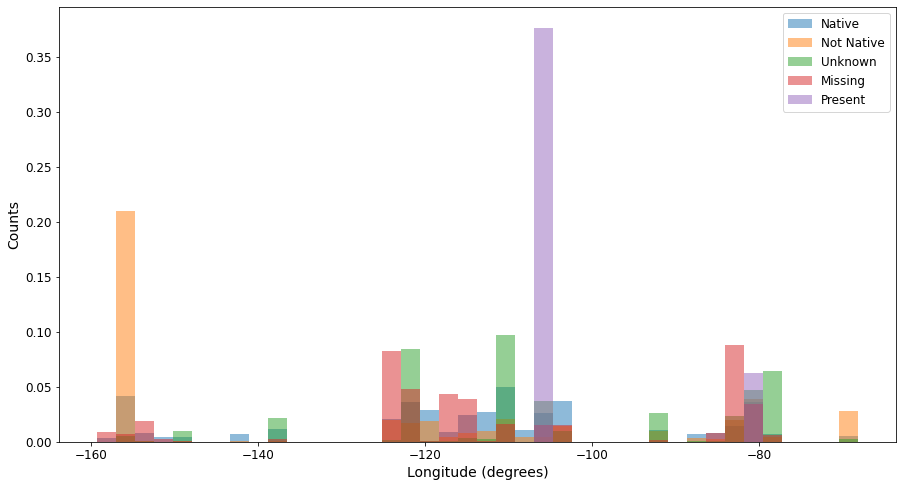

In [39]:
categories = df['Nativeness'].unique()
bin_range = (df['Longitude'].min(),df['Longitude'].max())

plt.figure(figsize = (15, 8))
for c in categories:
    plt.hist(df[df['Nativeness']==c]['Longitude'],alpha=0.5,label=c,range=bin_range,bins=40,density=True)
# plt.semilogy()
plt.legend(prop={'size': 12})
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Counts', fontsize = 14)
plt.xlabel('Longitude (degrees)', fontsize = 14)
plt.savefig("figures\Column Nativeness vs Longitude Categorical Histogram")

5) Park Name vs Abundance

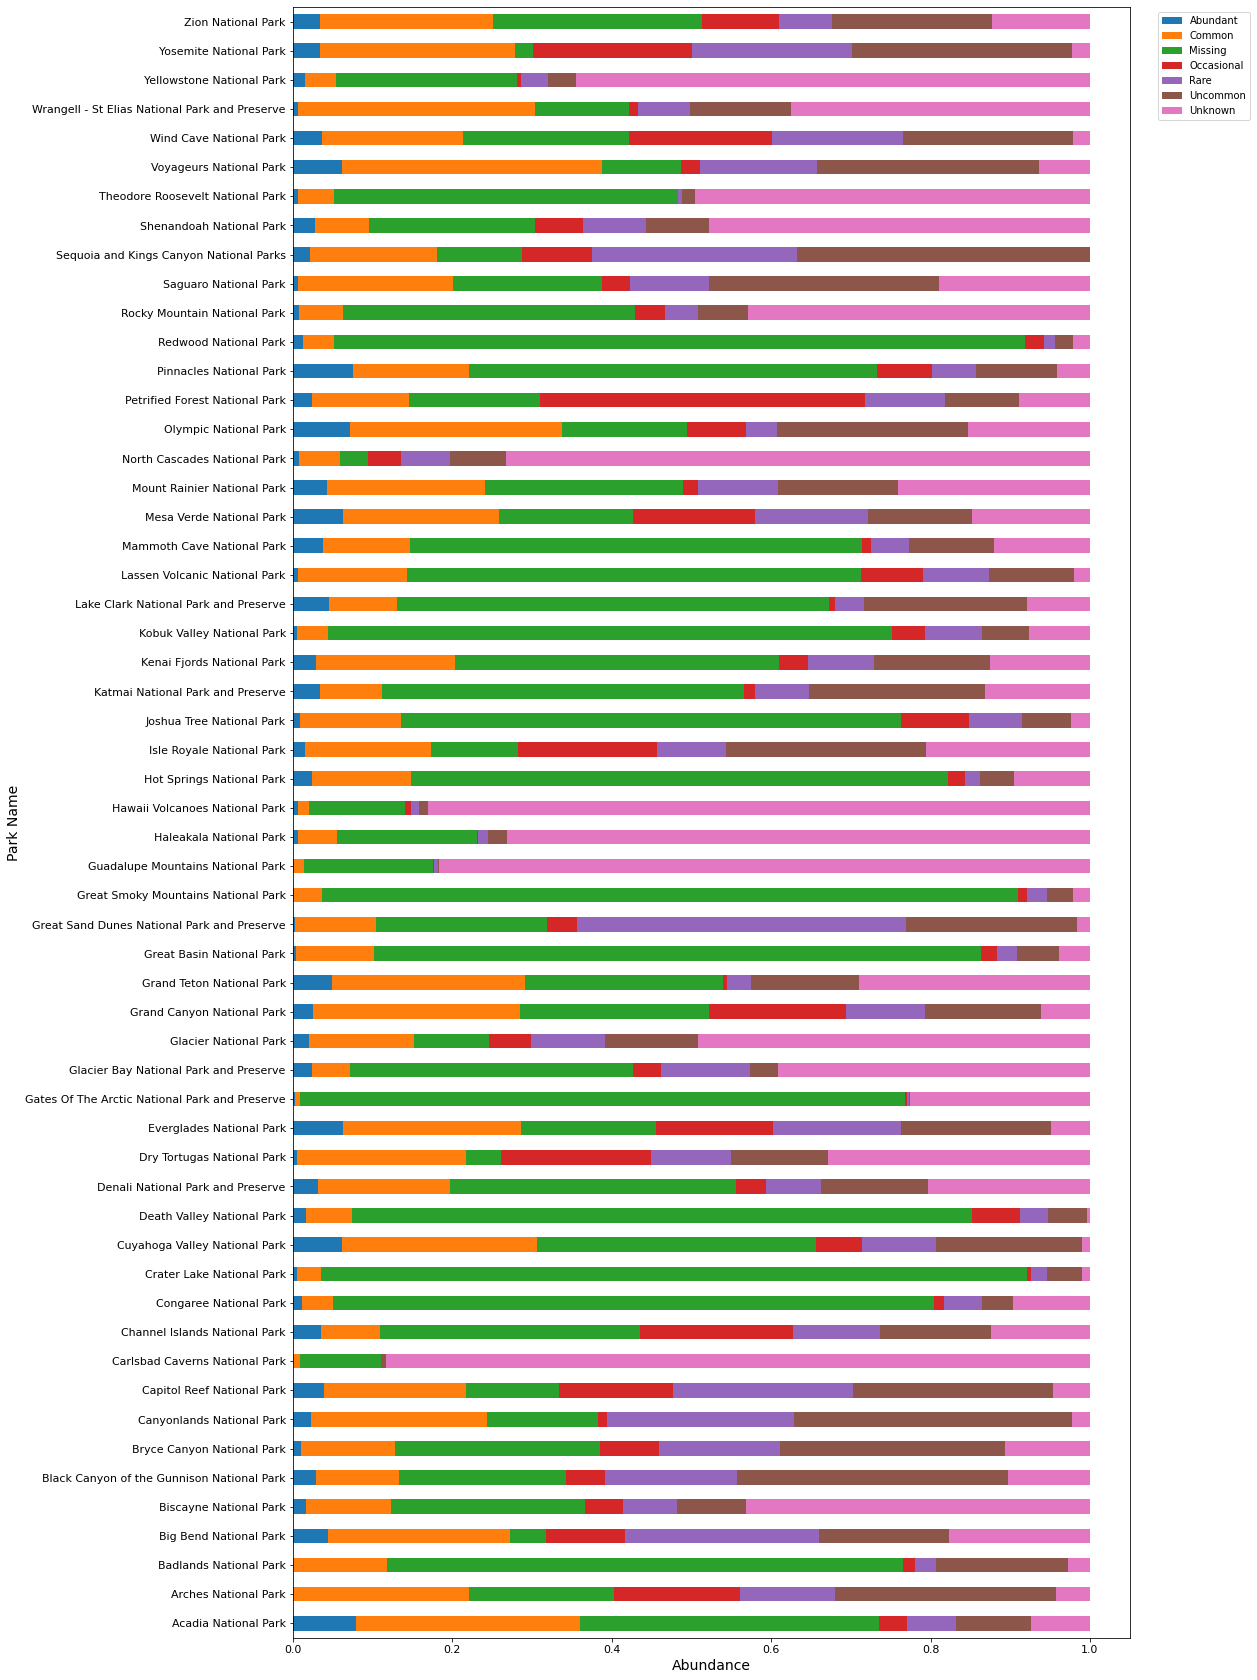

In [40]:
df = df2

count_matrix = df.groupby(['Park Name', 'Abundance']).size().unstack()
#print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
# print(count_matrix_norm)

count_matrix_norm.plot.barh(stacked=True, figsize = (15, 30))

# plt.xticks(rotation = 30, rotation_mode = "anchor", verticalalignment = "top", fontsize = 12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.ylabel('Park Name', fontsize = 14)
plt.xlabel('Abundance', fontsize = 14)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.savefig("figures\Abundance vs Park Name Stacked Bar Plot")

6) Park Name vs Area

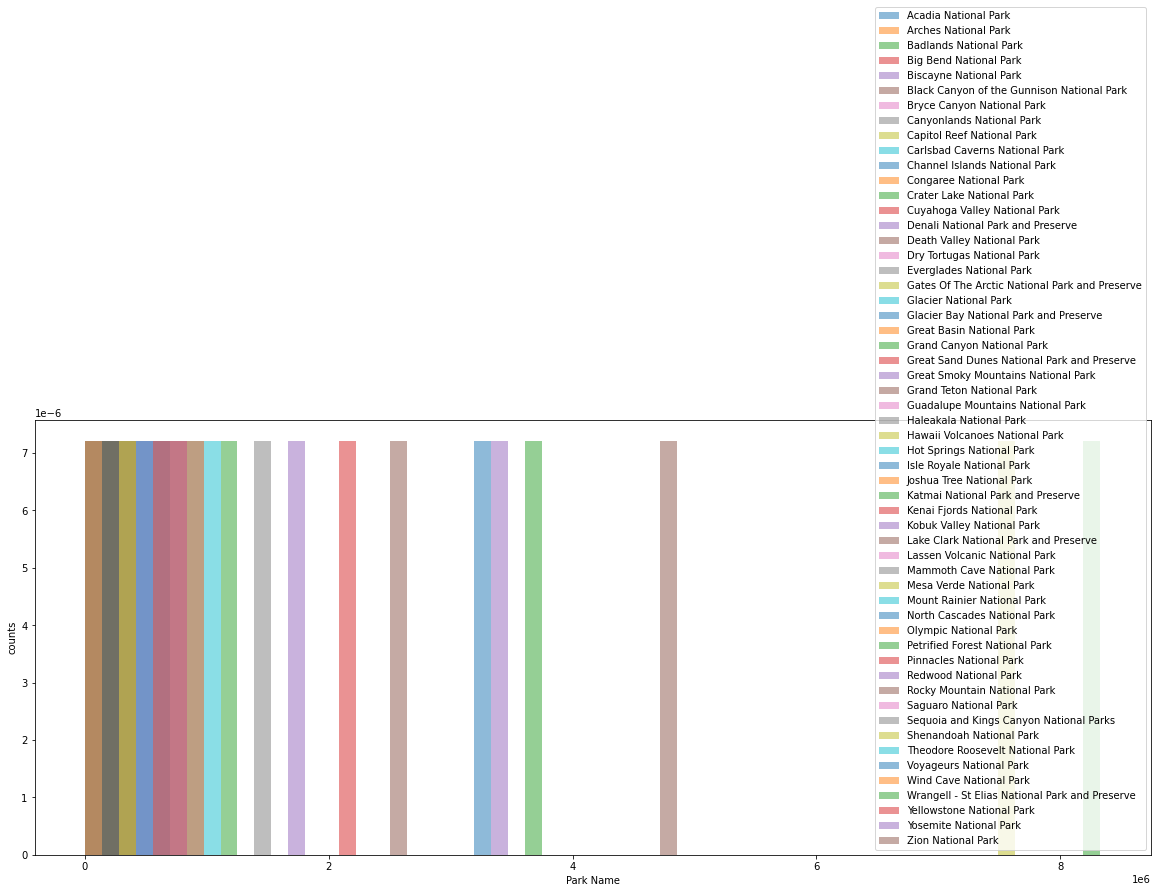

In [41]:
categories = df['Park Name'].unique()
bin_range = (df['Acres'].min(),df['Acres'].max())

plt.figure(figsize = (20, 8))
for c in categories:
    plt.hist(df[df['Park Name']==c]['Acres'],alpha=0.5,label=c,range=bin_range,bins=60,density=True)
# plt.semilogx()
plt.legend()
plt.ylabel('counts')
plt.xlabel('Park Name')
plt.savefig("figures\Park Name vs area of park category-specific histograms")

7) State vs Conservation

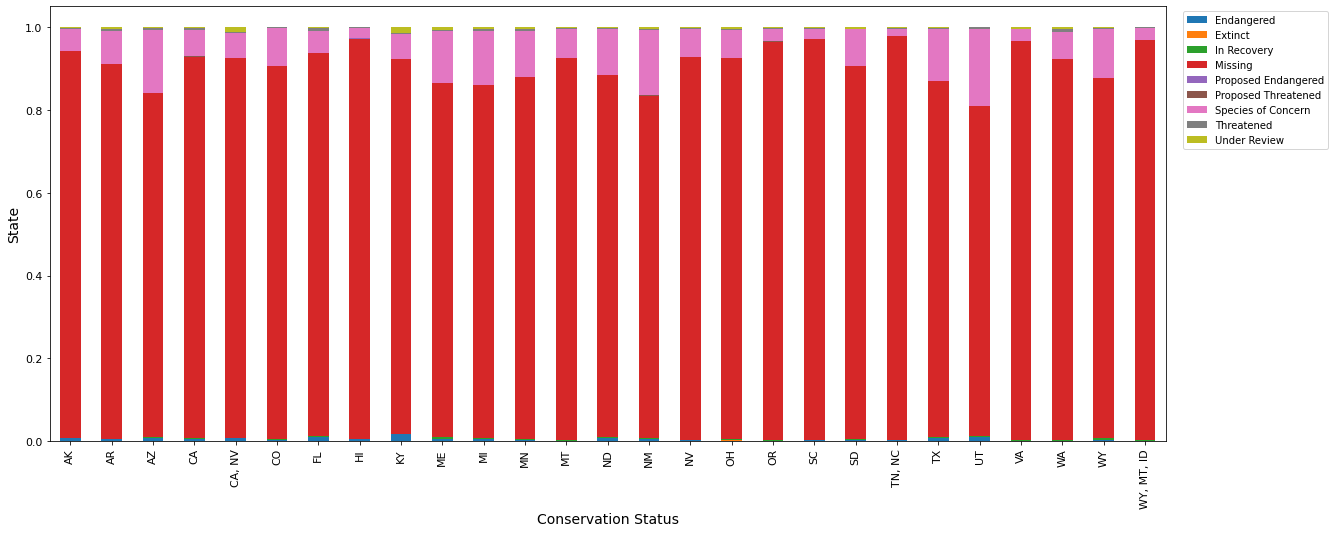

In [42]:
count_matrix = df.groupby(['State', 'Conservation Status']).size().unstack()
#print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
# print(count_matrix_norm)

count_matrix_norm.plot.bar(stacked=True, figsize = (20, 8))

# plt.xticks(rotation = 30, rotation_mode = "anchor", verticalalignment = "top", fontsize = 12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.ylabel('State', fontsize = 14)
plt.xlabel('Conservation Status', fontsize = 14)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.savefig("figures\State vs Conservation Status Stacked Bar Plot")

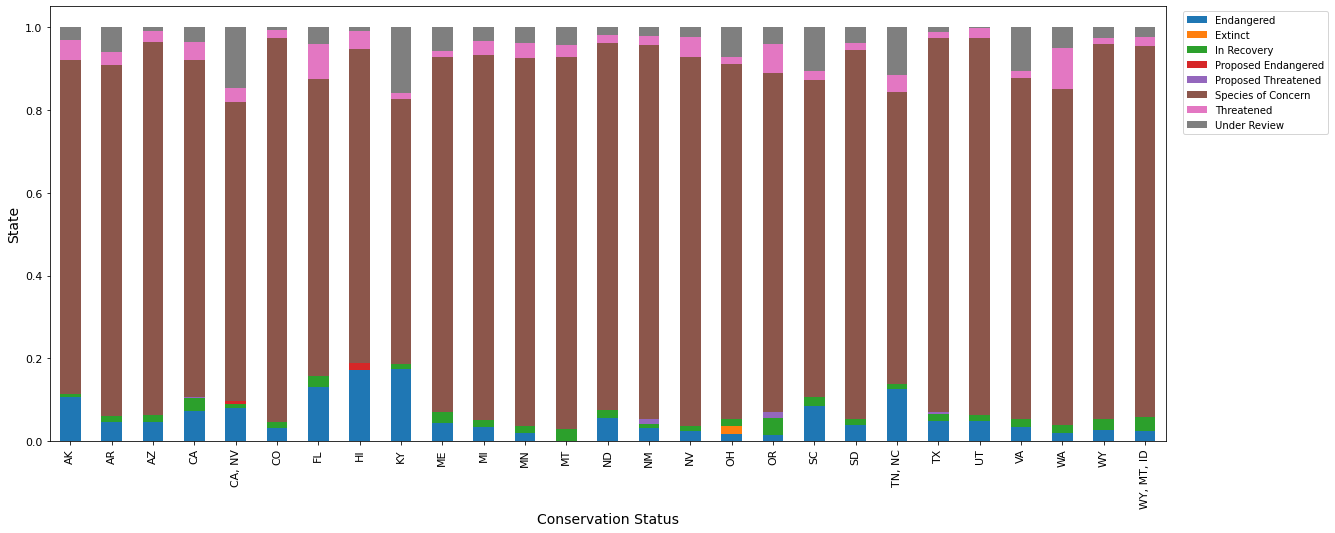

In [43]:
df_conservation = df2[(df2['Conservation Status']!='Missing')]
count_matrix = df_conservation.groupby(['State', 'Conservation Status']).size().unstack()
#print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
# print(count_matrix_norm)

count_matrix_norm.plot.bar(stacked=True, figsize = (20, 8))

# plt.xticks(rotation = 30, rotation_mode = "anchor", verticalalignment = "top", fontsize = 12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.ylabel('State', fontsize = 14)
plt.xlabel('Conservation Status', fontsize = 14)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.savefig("figures\State vs Conservation Status without Missing Stacked Bar Plot")

## Data Preprocessing

In [44]:
y = df2['Abundance'] 
X = df2.loc[:, df2.columns != 'Abundance'] # all other columns are features
z = df2['Park Name']

X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=z,random_state=42)   # first split
print('training set:',X_train.shape, y_train.shape)                           # 60% of points are in train
# z = X_train['Park Name']
# print(z.value_counts(normalize=True))

z_other = X_other['Park Name']
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=z_other,random_state=42)  # second split
print('validation set:',X_val.shape, y_val.shape)                             # 20% of points are in validation
print('test set:',X_test.shape, y_test.shape)                                 # 20% of points are in test
# z_other = X_other['Park Name']
# print(z.value_counts(normalize=True))

# preprocess categorical variables - used OneHotEncoder
onehot_ftrs = ['Category', 'Order', 'Family', 'Scientific Name', 'Record Status', 'Occurrence', 'Nativeness', 'Seasonality', 'Conservation Status', 'State']                                                        # initialize the encoder
enc = OneHotEncoder(sparse=False,handle_unknown='ignore') 
enc.fit(X_train[onehot_ftrs])                                                 # fit the training data
print('   feature names:',enc.get_feature_names(onehot_ftrs).shape)
onehot_train = enc.transform(X_train[onehot_ftrs])                            # transform X_train
onehot_val = enc.transform(X_val[onehot_ftrs])                                # transform X_val
onehot_test = enc.transform(X_test[onehot_ftrs])                              # transform X_test
                       
# preprocess continuous variables - used StandardScaler
std_ftrs = ['Acres', 'Latitude', 'Longitude']
scaler = StandardScaler()
scaler_train = scaler.fit_transform(X_train[std_ftrs])                        # fit the training data, transform X_train
scaler_val = scaler.transform(X_val[std_ftrs])                                # transform X_val
scaler_test = scaler.transform(X_test[std_ftrs])                              # transform X_test
print('   ', scaler_test[100])
        
# preprocess Y - used LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_val_le = le.transform(y_val)
y_test_le = le.transform(y_test)
print(y_test_le)
print(le.classes_)

training set: (29841, 14) (29841,)
validation set: (9947, 14) (9947,)
test set: (9947, 14) (9947,)
   feature names: (17596,)
    [-0.4665471  -0.08774252  1.48053129]
[4 5 1 ... 2 6 6]
['Abundant' 'Common' 'Missing' 'Occasional' 'Rare' 'Uncommon' 'Unknown']


In [45]:
y = df2['Abundance'] 
X = df2.loc[:, df2.columns != 'Abundance'] # all other columns are features
groups = df2['Park Name']

gss = GroupShuffleSplit(n_splits=3, train_size=.6, random_state=42)                  # split into training and other sets
for train_index, other_index in gss.split(X, y, groups):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_other = X.iloc[other_index]
    y_other = y.iloc[other_index]
    print('   training set:',X_train.shape, y_train.shape) 
    # print(X_train[['Park Name']].head())

    gss2 = GroupShuffleSplit(n_splits=1, train_size=.5, random_state=42)    
    groups_other = X_other[['Park Name']]
    for val_index, test_index in gss2.split(X_other,y_other, groups_other):           # split into validation and test sets
        X_val = X_other.iloc[val_index]
        y_val = y_other.iloc[val_index]
        X_test = X_other.iloc[test_index]
        y_test = y_other.iloc[test_index]
        
        print('   validation set:',X_val.shape, y_val.shape) 
        print('   test set:',X_test.shape, y_test.shape) 
        # print(X_val[['Park Name']].head())
        # print(X_test[['Park Name']].head())
        
        # preprocess categorical variables - used OneHotEncoder
        onehot_ftrs = ['Category', 'Order', 'Family', 'Scientific Name', 'Record Status', 'Occurrence', 'Nativeness', 'Seasonality', 'Conservation Status', 'State']                                                        # initialize the encoder
        enc = OneHotEncoder(sparse=False,handle_unknown='ignore') 
        enc.fit(X_train[onehot_ftrs])                                                 # fit the training data
        print('   feature names:',enc.get_feature_names(onehot_ftrs).shape)
        onehot_train = enc.transform(X_train[onehot_ftrs])                            # transform X_train
        onehot_val = enc.transform(X_val[onehot_ftrs])                                # transform X_val
        onehot_test = enc.transform(X_test[onehot_ftrs])                              # transform X_test
                       
        # preprocess continuous variables - used StandardScaler
        std_ftrs = ['Acres', 'Latitude', 'Longitude']
        scaler = StandardScaler()
        scaler_train = scaler.fit_transform(X_train[std_ftrs])                        # fit the training data, transform X_train
        scaler_val = scaler.transform(X_val[std_ftrs])                                # transform X_val
        scaler_test = scaler.transform(X_test[std_ftrs])                              # transform X_test
        print('   ', scaler_test[100])
        
        # preprocess Y - used LabelEncoder
        le = LabelEncoder()
        y_train_le = le.fit_transform(y_train)
        y_val_le = le.transform(y_val)
        y_test_le = le.transform(y_test)
        print(y_test_le)

   training set: (31539, 14) (31539,)
   validation set: (6639, 14) (6639,)
   test set: (11557, 14) (11557,)
   feature names: (18858,)
    [-0.62355734  0.57454935  1.88451257]
[4 0 1 ... 2 2 2]
   training set: (29477, 14) (29477,)
   validation set: (9511, 14) (9511,)
   test set: (10747, 14) (10747,)
   feature names: (17888,)
    [-0.67880005  0.46173031  1.81026396]
[4 0 1 ... 2 2 2]
   training set: (29512, 14) (29512,)
   validation set: (11211, 14) (11211,)
   test set: (9012, 14) (9012,)
   feature names: (17680,)
    [-0.48794418 -0.04168767  0.09045217]
[5 5 6 ... 2 2 2]
